In [1]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 61kB 3.4MB/s 
     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x660cc000 @  0x7f4883155615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx

npx.set_np()

In [3]:
batch_size, max_len = 512, 512
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)
net = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256,
                    num_heads=2, num_layers=2, dropout=0.2)
devices = d2l.try_all_gpus()
net.initialize(init.Xavier(), ctx=devices)
loss = gluon.loss.SoftmaxCELoss()
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X_shards,
                         segments_X_shards, valid_lens_x_shards,
                         pred_positions_X_shards, mlm_weights_X_shards,
                         mlm_Y_shards, nsp_y_shards):
    mlm_ls, nsp_ls, ls = [], [], []
    for (tokens_X_shard, segments_X_shard, valid_lens_x_shard,
         pred_positions_X_shard, mlm_weights_X_shard, mlm_Y_shard,
         nsp_y_shard) in zip(
        tokens_X_shards, segments_X_shards, valid_lens_x_shards,
        pred_positions_X_shards, mlm_weights_X_shards, mlm_Y_shards,
        nsp_y_shards):
        # Forward pass
        _, mlm_Y_hat, nsp_Y_hat = net(
            tokens_X_shard, segments_X_shard, valid_lens_x_shard.reshape(-1),
            pred_positions_X_shard)
        # Compute masked language model loss
        mlm_l = loss(
            mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y_shard.reshape(-1),
            mlm_weights_X_shard.reshape((-1, 1)))
        mlm_l = mlm_l.sum() / (mlm_weights_X_shard.sum() + 1e-8)
        # Compute next sentence prediction loss
        nsp_l = loss(nsp_Y_hat, nsp_y_shard)
        nsp_l = nsp_l.mean()
        mlm_ls.append(mlm_l)
        nsp_ls.append(nsp_l)
        ls.append(mlm_l + nsp_l)
        npx.waitall()
    return mlm_ls, nsp_ls, ls
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': 1e-3})
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for batch in train_iter:
            (tokens_X_shards, segments_X_shards, valid_lens_x_shards,
             pred_positions_X_shards, mlm_weights_X_shards,
             mlm_Y_shards, nsp_y_shards) = [gluon.utils.split_and_load(
                elem, devices, even_split=False) for elem in batch]
            timer.start()
            with autograd.record():
                mlm_ls, nsp_ls, ls = _get_batch_loss_bert(
                    net, loss, vocab_size, tokens_X_shards, segments_X_shards,
                    valid_lens_x_shards, pred_positions_X_shards,
                    mlm_weights_X_shards, mlm_Y_shards, nsp_y_shards)
            for l in ls:
                l.backward()
            trainer.step(1)
            mlm_l_mean = sum([float(l) for l in mlm_ls]) / len(mlm_ls)
            nsp_l_mean = sum([float(l) for l in nsp_ls]) / len(nsp_ls)
            metric.add(mlm_l_mean, nsp_l_mean, batch[0].shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break


    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MXNetError: ignored

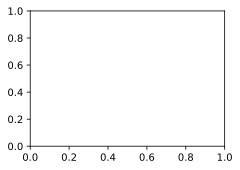

In [4]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [ ]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = np.expand_dims(np.array(vocab[tokens], ctx=devices[0]),
                               axis=0)
    segments = np.expand_dims(np.array(segments, ctx=devices[0]), axis=0)
    valid_len = np.expand_dims(np.array(len(tokens), ctx=devices[0]), axis=0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

In [ ]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

((1, 10, 128),
 (1, 128),
 array([ 0.81067115,  0.88837487, -1.0412929 ], ctx=gpu(0)))